## Librerias

In [1]:
import pandas as pd
import numpy as np
from google.cloud import bigquery
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Deshabilitar el modo interactivo
plt.ioff()

## Funciones

In [2]:
class Graficador:

    def __init__(self):
        pass

    def create_subplots_one_var(self,data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)

        for column in data.columns:

            # Creacion del grafico de barras
            graph(data = data[[column]], ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

    def create_subplots_one_var_group(self, data, n_rows, n_cols, graph, fig_size = (30,25)):
        # Indices de la grilla de graficos de matplotlib
        i = 0
        j = 0

        # Creacion de la grilla de graficos
        fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = fig_size)
        data_temp = data[::]
        data_temp['temp'] = 0
        for column in data_temp.columns:
            
            if column == 'temp':
                continue

            temp = data_temp[[column, 'temp']].groupby(column, as_index = False).count().rename(columns = {'temp' : 'Conteo'})
            # Creacion del grafico de barras
            graph(data = temp, x = column, y = 'Conteo', ax = axes[i,j])

            # Se añade el titulo a la grafica
            axes[i,j].set_title(f'{column}')

            # Indices para poder ir agregando los graficos
            j += 1
            if j > n_cols - 1:
                j = 0
                i+=1

        return fig, axes

def create_apilated_bars(data):

    grupos = data.columns

    fig, ax = plt.subplots()
    values = data.values

    for i in range(values.shape[0]):
        ax.bar(grupos, values[i], bottom = np.sum(values[:i], axis = 0), label = data.index[i])
        # Agregar títulos a los ejes

    return fig,ax


def outlier_label(value, limit):
    if value < limit[0]:
        return 'Abajo'
    elif value > limit[1]:
        return 'Arriba'
    else:
        return 'No'

def take_outliers(data, variable):
    Q1 = data[variable].quantile(0.25)
    Q3 = data[variable].quantile(0.75)
    RIC = Q3 - Q1
    limit_inf = Q1 - (1.5 * RIC)
    limit_sup = Q3 + (1.5 * RIC)
    data[f'{variable}_outlier'] = data[variable].apply(lambda x: outlier_label(x, [limit_inf,limit_sup]))
    return data

## Parametros

In [3]:
client_bq = bigquery.Client()

In [4]:
table = 'Diabetes_avicena_survival.diabetes_final_3_annos'

variables_with_outliers = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal']

numeric_columns = ['edad','IMC','HDL','LDL','trigliceridos','perimetro_abdominal','time_to_event']
categoric_columns = ['genero_paciente','raza_paciente','nivel_academico_paciente','ant_cardio','med_hipertension','ant_familiar_dm','hace_ejercicio']
target = 'diabetes'

In [5]:
graficador = Graficador()

## Proceso

In [6]:
data = client_bq.query(f'SELECT * FROM {table}').result().to_dataframe()
print(f'Se trajo {data.shape} datos de pacientes')
data.head()

Se trajo (735003, 21) datos de pacientes


,numero_identificacion_paciente,year,month,fecha,edad,peso,talla,IMC,HDL,LDL,...,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
0,1003390652,2022,2,2022-02-01,26,105.233333,1.60,41.106770833,71.20,106.14,...,111.0,Femenino,Mestizo,Bachillerato técnico,0,0,0,None,0,34
1,1006578626,2022,2,2022-02-01,20,68.700000,1.77,21.928564589,56.25,143.00,...,NaN,Masculino,Otros,Profesional,1,0,0,None,0,36
2,1007218577,2022,2,2022-02-01,28,74.300000,1.78,23.450321929,45.10,96.64,...,NaN,Masculino,Otros,Ninguno,0,0,0,None,0,33
3,1010021506,2022,2,2022-02-01,36,71.000000,1.60,27.734375000,60.00,140.00,...,NaN,Masculino,Otros,Tecnológica,1,1,0,None,0,35
4,10241950,2022,2,2022-02-01,67,85.800000,1.72,29.002163332,41.00,82.00,...,105.0,Masculino,Otros,Básica secundaria,1,1,0,None,1,13


In [20]:
# outliers

data_label = data.copy()
data_label['IMC'] = np.round(data_label['IMC'].astype(float),2)

for variable in variables_with_outliers:
    print(variable)
    data_label = take_outliers(data_label, variable)
    
for variable in variables_with_outliers:
    print(variable)
    conteos = data_label[f'{variable}_outlier'].value_counts().reset_index()
    total = conteos['count'].sum()
    conteos['Porcentaje'] = (conteos['count'] / total)*100
    display(conteos)
    
columns_to_drop = [column + '_outlier' for column in variables_with_outliers]

data_clean_outliers = data_label[(data_label.edad_outlier == 'No') &
                                 (data_label.IMC_outlier == 'No') &
                                 (data_label.HDL_outlier == 'No') &
                                 (data_label.LDL_outlier == 'No') &
                                 (data_label.trigliceridos_outlier == 'No') &
                                 (data_label.perimetro_abdominal_outlier == 'No')
                                ]

data_clean_outliers = data_clean_outliers.drop(columns = columns_to_drop)
data_clean_outliers = data_clean_outliers.drop(columns = ['peso','talla'])

data_clean_outliers

edad
IMC
HDL
LDL
trigliceridos
perimetro_abdominal
edad


,edad_outlier,count,Porcentaje
0,No,734941,99.991565
1,Arriba,62,0.008435


IMC


,IMC_outlier,count,Porcentaje
0,No,716847,97.529806
1,Arriba,17400,2.367337
2,Abajo,756,0.102857


HDL


,HDL_outlier,count,Porcentaje
0,No,717920,97.675792
1,Arriba,16801,2.285841
2,Abajo,282,0.038367


LDL


,LDL_outlier,count,Porcentaje
0,No,726296,98.815379
1,Arriba,8065,1.097274
2,Abajo,642,0.087347


trigliceridos


,trigliceridos_outlier,count,Porcentaje
0,No,701873,95.492535
1,Arriba,33130,4.507465


perimetro_abdominal


,perimetro_abdominal_outlier,count,Porcentaje
0,No,728156,99.068439
1,Arriba,5590,0.760541
2,Abajo,1257,0.171020


,numero_identificacion_paciente,year,month,fecha,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes,time_to_event
1,1006578626,2022,2,2022-02-01,20,21.93,56.25,143.00,100.05,NaN,Masculino,Otros,Profesional,1,0,0,None,0,36
2,1007218577,2022,2,2022-02-01,28,23.45,45.10,96.64,64.68,NaN,Masculino,Otros,Ninguno,0,0,0,None,0,33
3,1010021506,2022,2,2022-02-01,36,27.73,60.00,140.00,117.00,NaN,Masculino,Otros,Tecnológica,1,1,0,None,0,35
4,10241950,2022,2,2022-02-01,67,29.00,41.00,82.00,203.00,105.0,Masculino,Otros,Básica secundaria,1,1,0,None,1,13
5,10529330,2022,2,2022-02-01,66,25.78,46.50,46.30,109.00,NaN,Masculino,Otros,Básica secundaria,1,1,0,None,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734998,80503895,2025,1,2025-01-01,52,33.96,30.00,116.00,275.00,105.0,Masculino,Otros,Básica secundaria,0,0,0,None,1,21
734999,8298242,2025,1,2025-01-01,76,22.66,47.90,65.62,92.40,72.0,Masculino,Otros,Profesional,0,0,0,20 minutos,1,35
735000,8670023,2025,1,2025-01-01,70,22.84,42.00,58.00,183.00,NaN,Masculino,Otros,Profesional,0,1,0,None,1,35
735001,9068399,2025,1,2025-01-01,82,29.01,39.00,154.00,177.00,NaN,Masculino,Otros,Profesional,1,1,0,None,0,1


In [7]:
## Cantidad de pacientes con diabetes
data[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()

,diabetes,numero_identificacion_paciente
0,0,585512
1,1,149491


In [ ]:
## Cantidad de pacientes con diabetes
data_clean_outliers[['numero_identificacion_paciente','diabetes']].drop_duplicates().groupby('diabetes', as_index = False).count()

In [33]:
# data_clean_outliers.to_csv('datas_no_outliers.csv', sep = '|', index = False)

## Filtrar datos Categoricos y numericos

In [34]:
# Dataframe con los datos numericos
df_numerico = data[numeric_columns]
df_numerico['IMC'] = np.round(df_numerico['IMC'].astype(float),2)

print(data_clean_outliers.shape)
df_numerico.head()

(657091, 19)


,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
0,26,41.11,71.20,106.14,117.80,111.0,34
1,20,21.93,56.25,143.00,100.05,NaN,36
2,28,23.45,45.10,96.64,64.68,NaN,33
3,36,27.73,60.00,140.00,117.00,NaN,35
4,67,29.00,41.00,82.00,203.00,105.0,13


In [35]:
# Dataframe con los datos categoricos
df_categorico = data[categoric_columns + [target]].astype(str)

print(data_clean_outliers.shape)
df_categorico.head()

(657091, 19)


,genero_paciente,raza_paciente,nivel_academico_paciente,ant_cardio,med_hipertension,ant_familiar_dm,hace_ejercicio,diabetes
0,Femenino,Mestizo,Bachillerato técnico,0,0,0,None,0
1,Masculino,Otros,Profesional,1,0,0,None,0
2,Masculino,Otros,Ninguno,0,0,0,None,0
3,Masculino,Otros,Tecnológica,1,1,0,None,0
4,Masculino,Otros,Básica secundaria,1,1,0,None,1


## One Variable

In [36]:
## informacion de la data
df_numerico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735003 entries, 0 to 735002
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   edad                 735003 non-null  Int64  
 1   IMC                  735003 non-null  float64
 2   HDL                  735003 non-null  float64
 3   LDL                  735003 non-null  float64
 4   trigliceridos        735003 non-null  float64
 5   perimetro_abdominal  319193 non-null  float64
 6   time_to_event        735003 non-null  Int64  
dtypes: Int64(2), float64(5)
memory usage: 40.7 MB


In [37]:
## Descripcion de los datos
df_numerico.describe()

,edad,IMC,HDL,LDL,trigliceridos,perimetro_abdominal,time_to_event
count,735003.0,735003.000000,735003.000000,735003.000000,735003.000000,319193.000000,735003.0
mean,55.246026,27.822222,48.339312,117.673353,157.202521,93.125016,17.497995
std,15.920614,5.521441,36.445320,77.459818,803.760089,12.805410,10.348544
min,18.0,0.100000,0.000000,-113.860000,0.000000,20.000000,1.0
25%,44.0,24.460000,39.000000,89.600000,96.800000,85.000000,8.0
50%,56.0,27.240000,46.300000,115.000000,133.000000,92.000000,18.0
75%,67.0,30.480000,55.000000,142.000000,186.000000,100.500000,27.0
max,111.0,993.330000,22545.780000,34159.000000,386000.000000,241.000000,36.0


Grafico de distribuciones


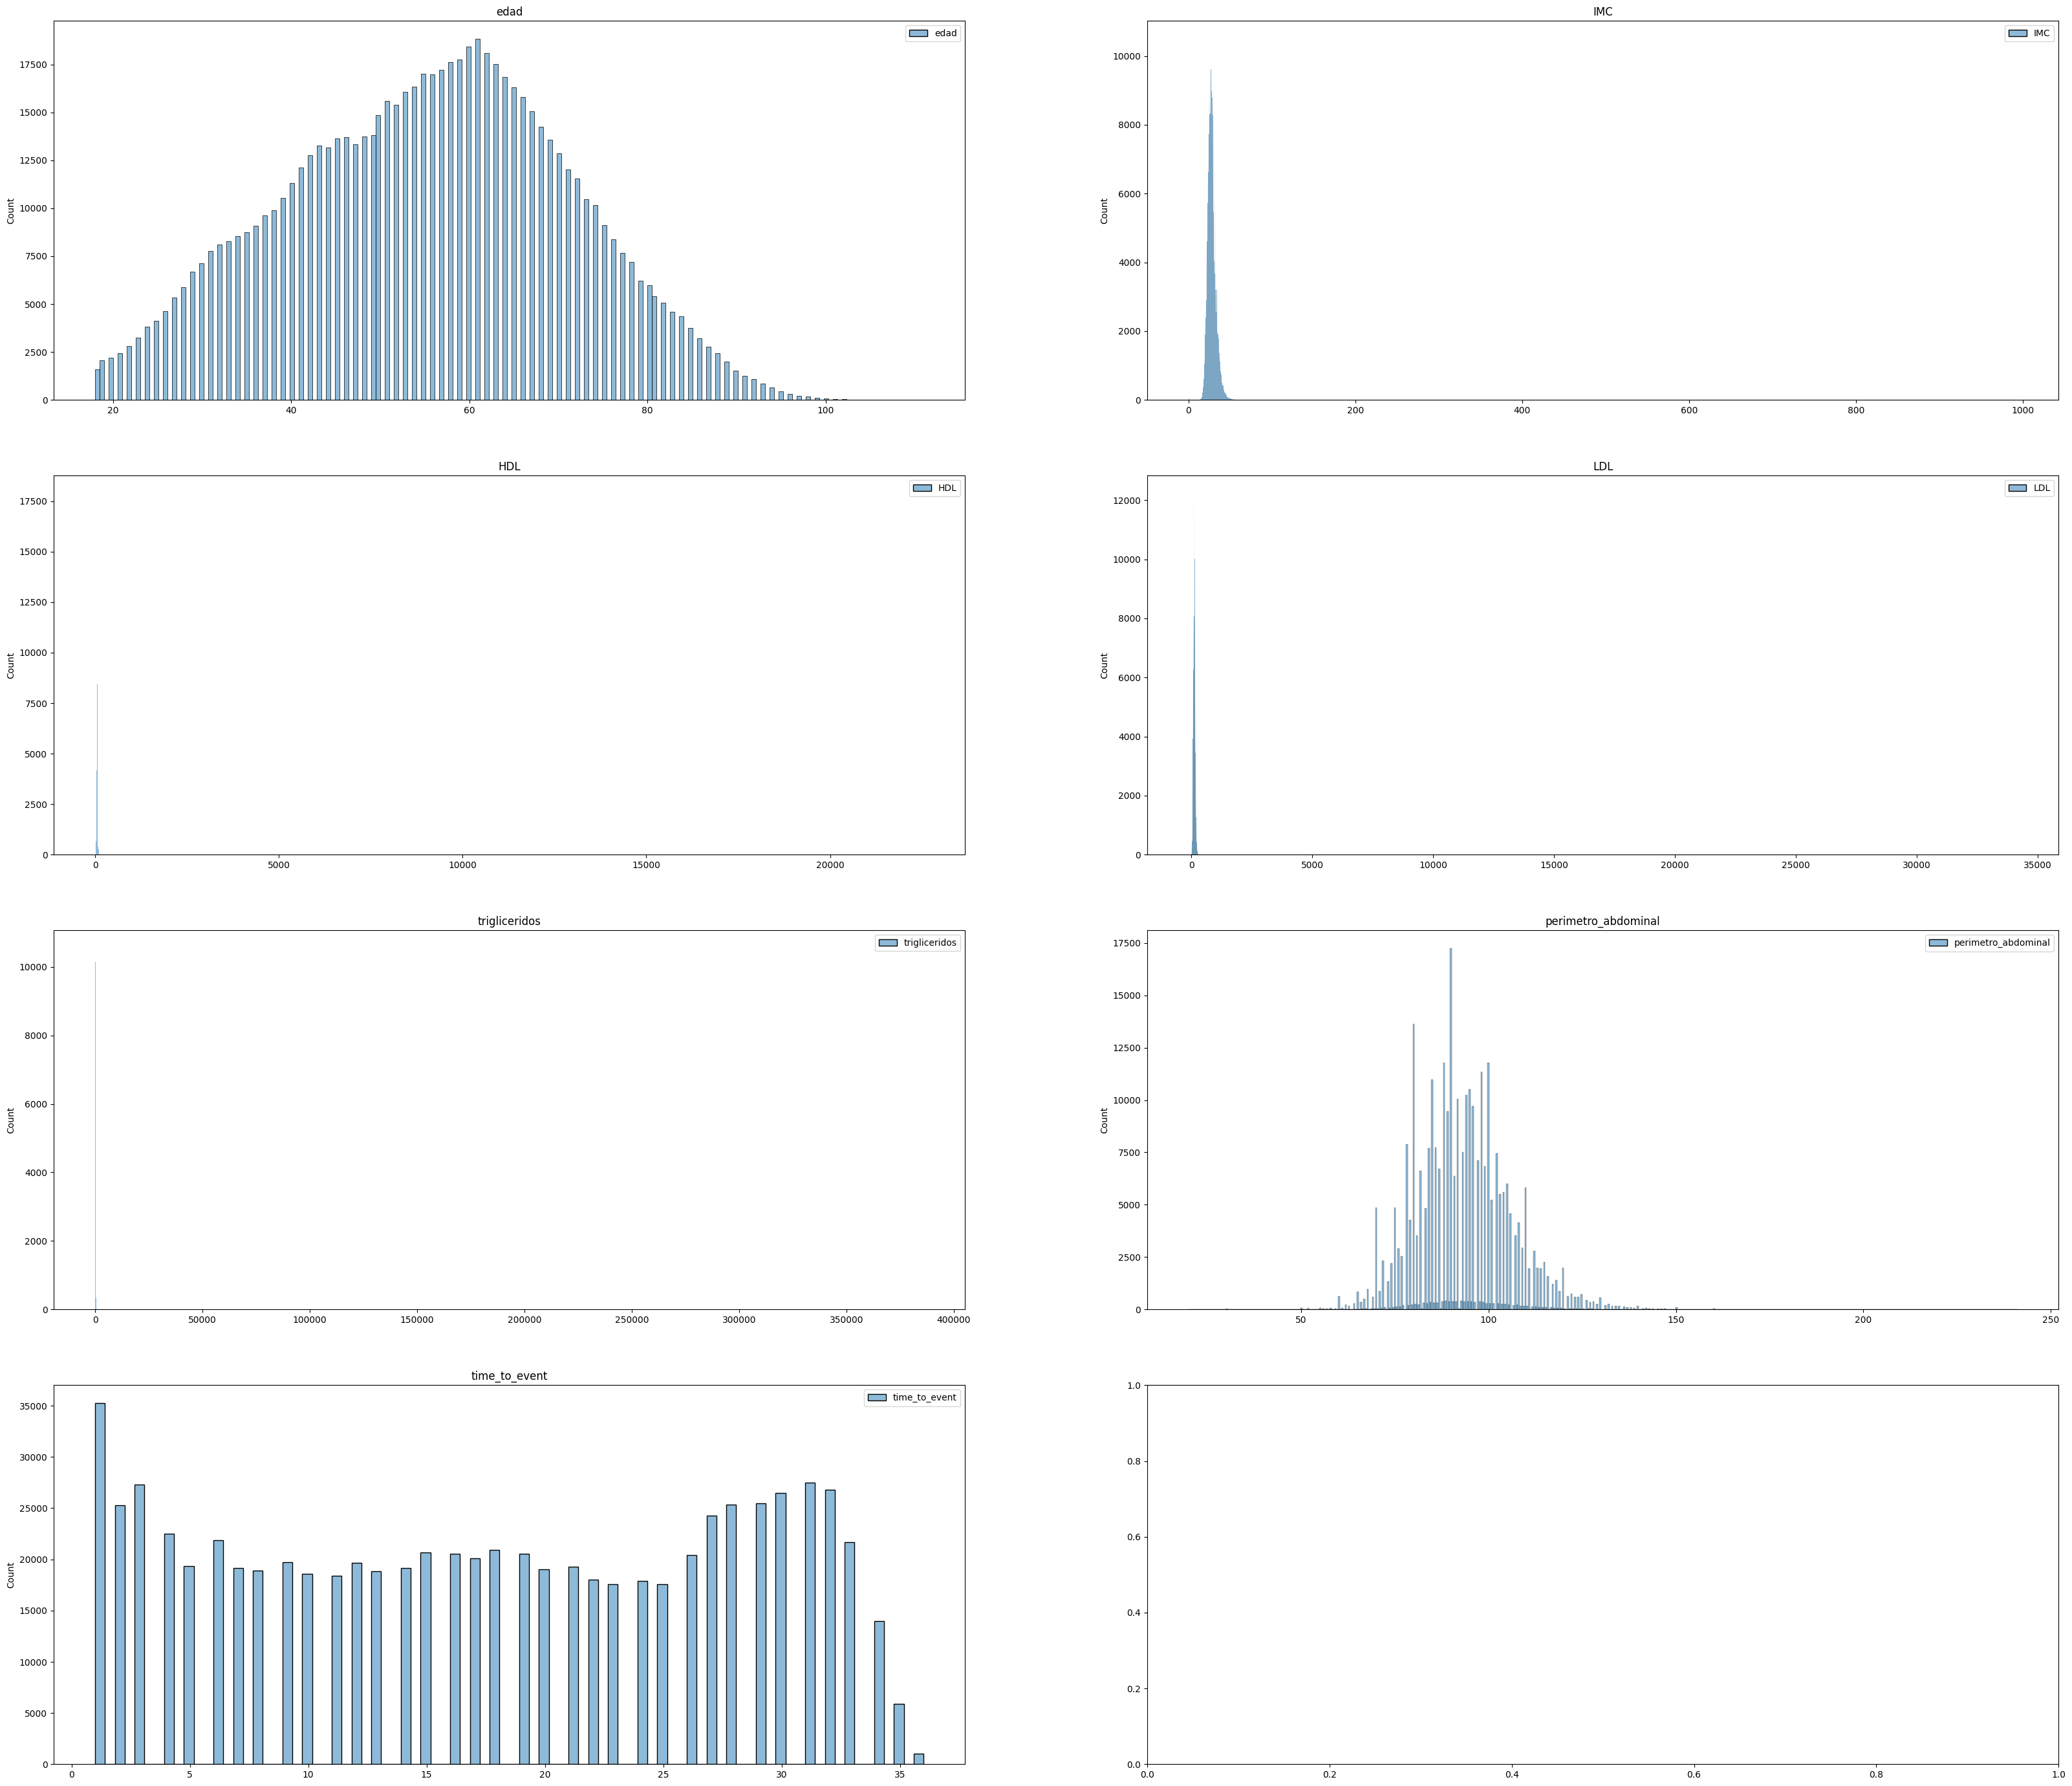

In [38]:
print('Grafico de distribuciones')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.histplot, fig_size = (40,35))
plt.show()

Grafico de caja y bigotes


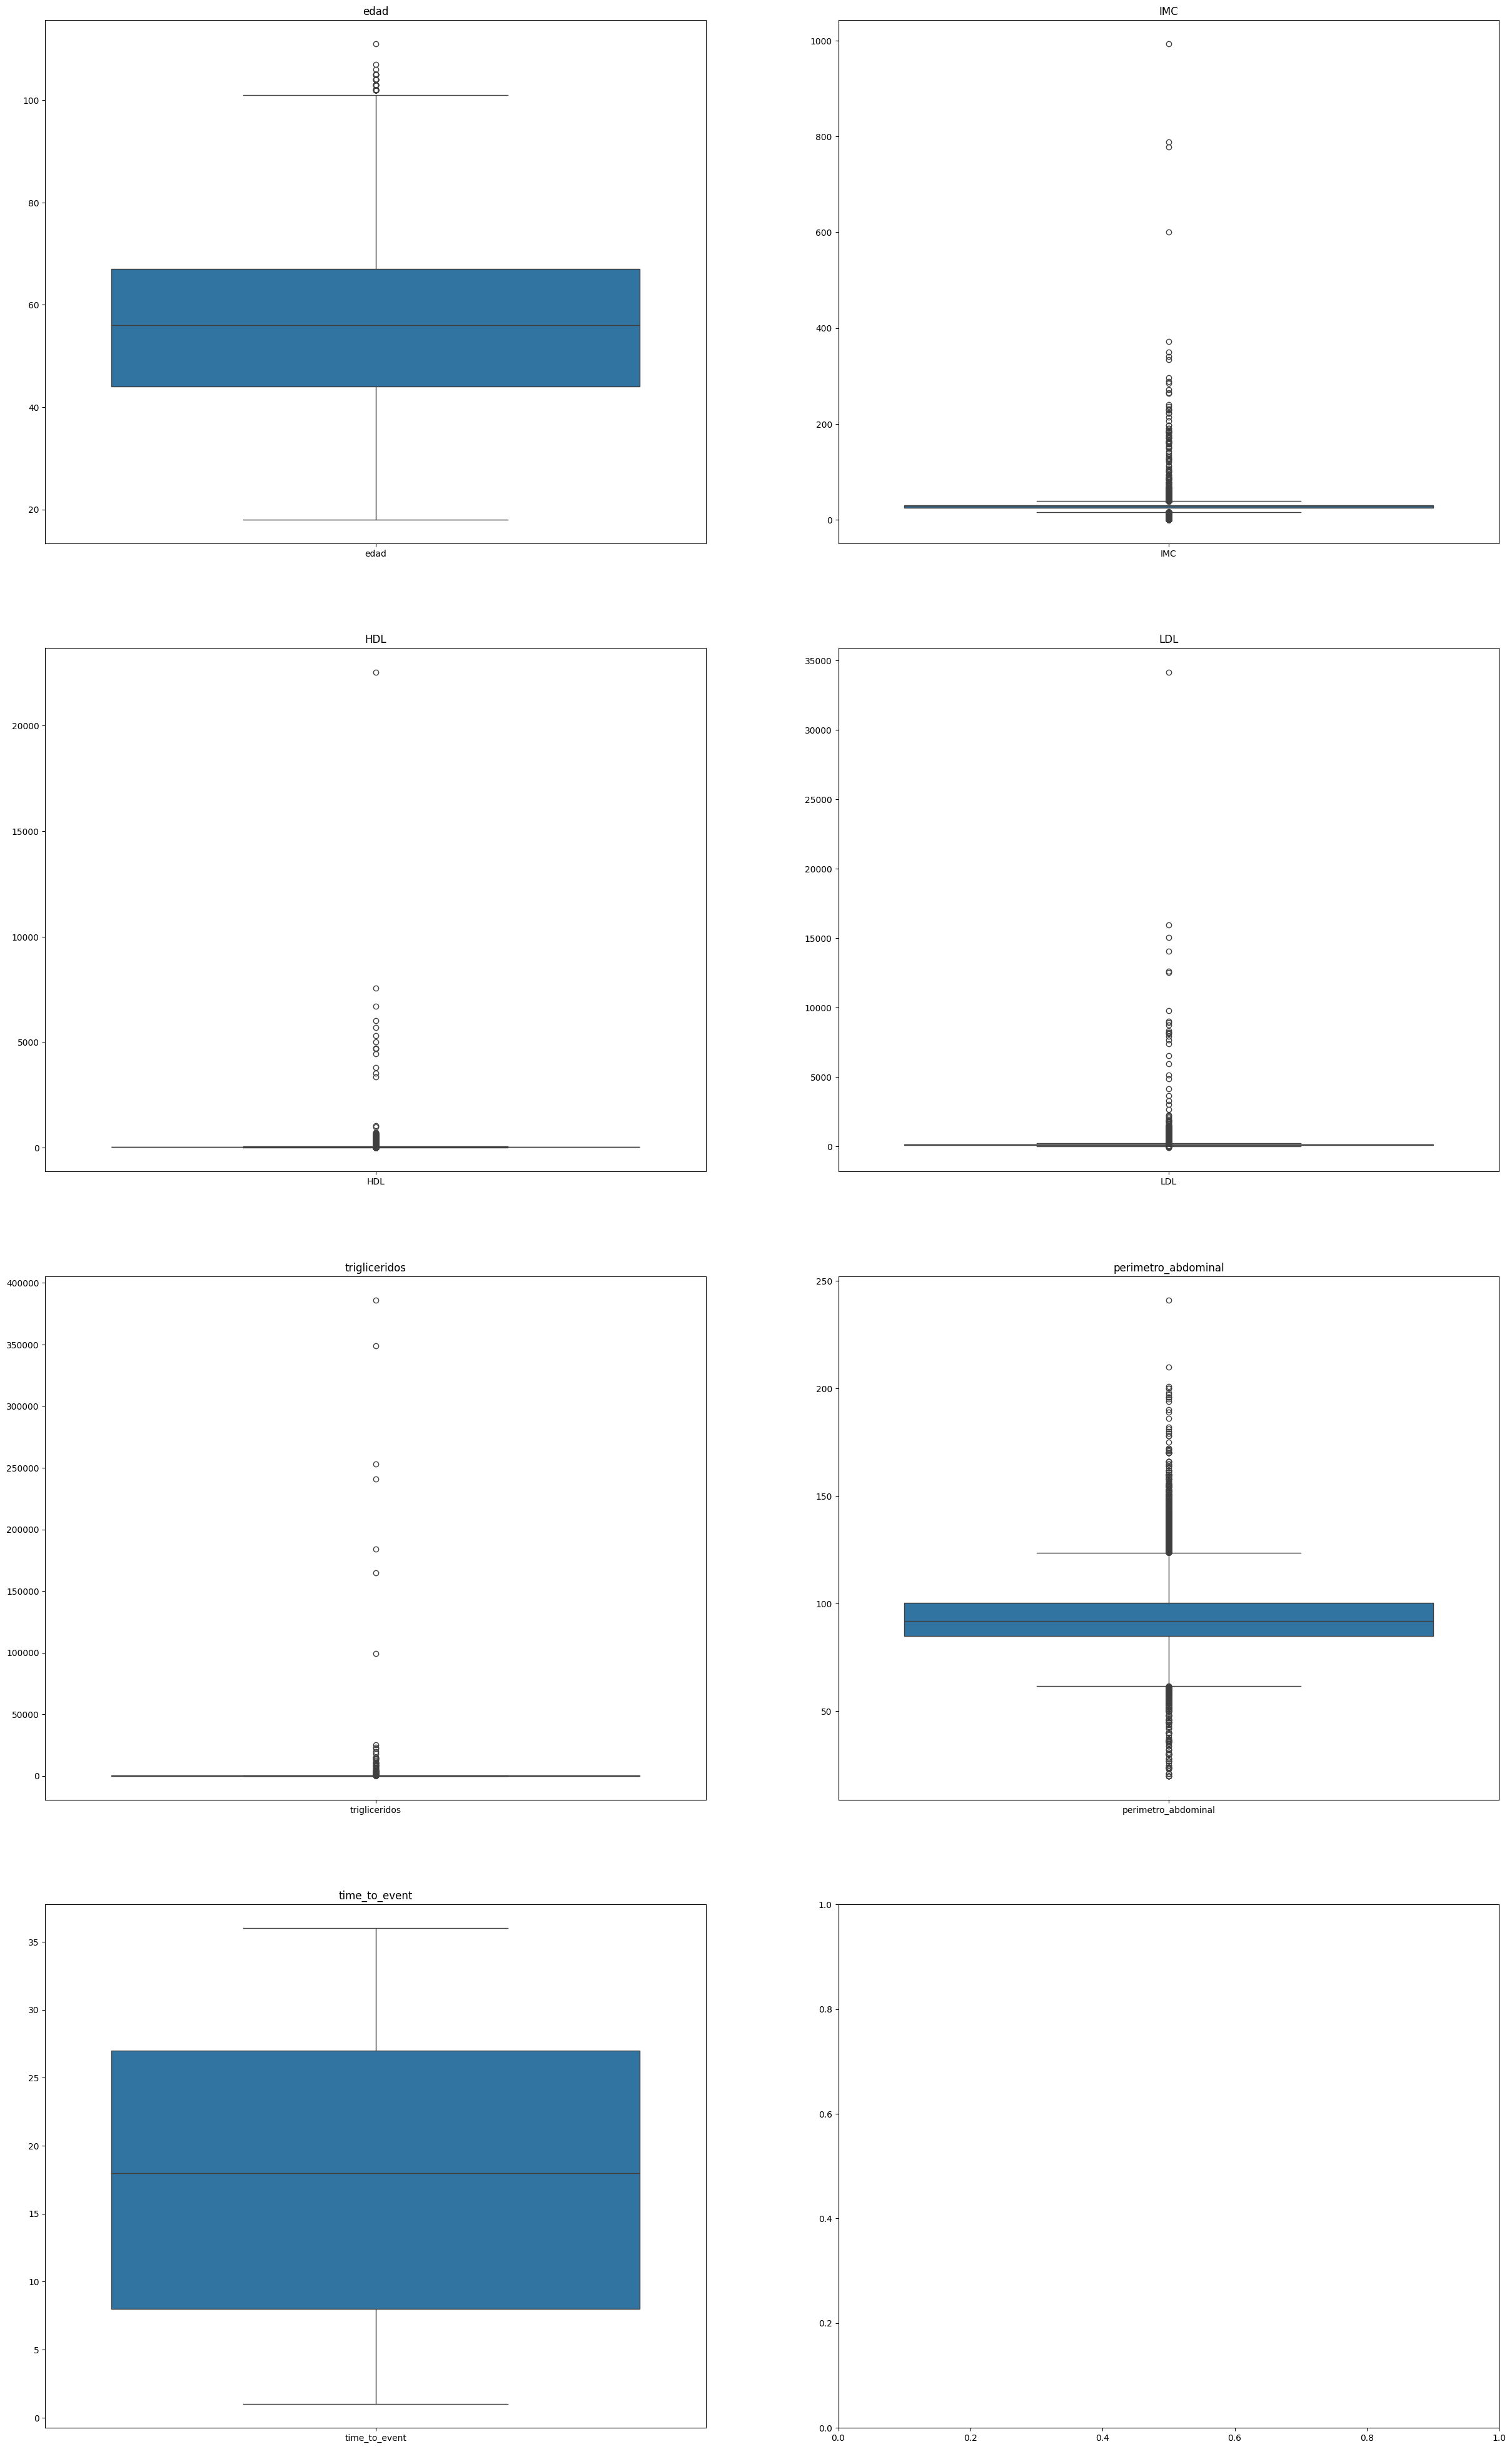

In [39]:
print('Grafico de caja y bigotes')
fig, axes = graficador.create_subplots_one_var(data = df_numerico, n_cols = 2, n_rows = 4, graph= sns.boxplot, fig_size=(30,50))
plt.show()

In [40]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735003 entries, 0 to 735002
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   genero_paciente           735003 non-null  object
 1   raza_paciente             735003 non-null  object
 2   nivel_academico_paciente  735003 non-null  object
 3   ant_cardio                735003 non-null  object
 4   med_hipertension          735003 non-null  object
 5   ant_familiar_dm           735003 non-null  object
 6   hace_ejercicio            735003 non-null  object
 7   diabetes                  735003 non-null  object
dtypes: object(8)
memory usage: 44.9+ MB


Conteos de cada una de las categorias


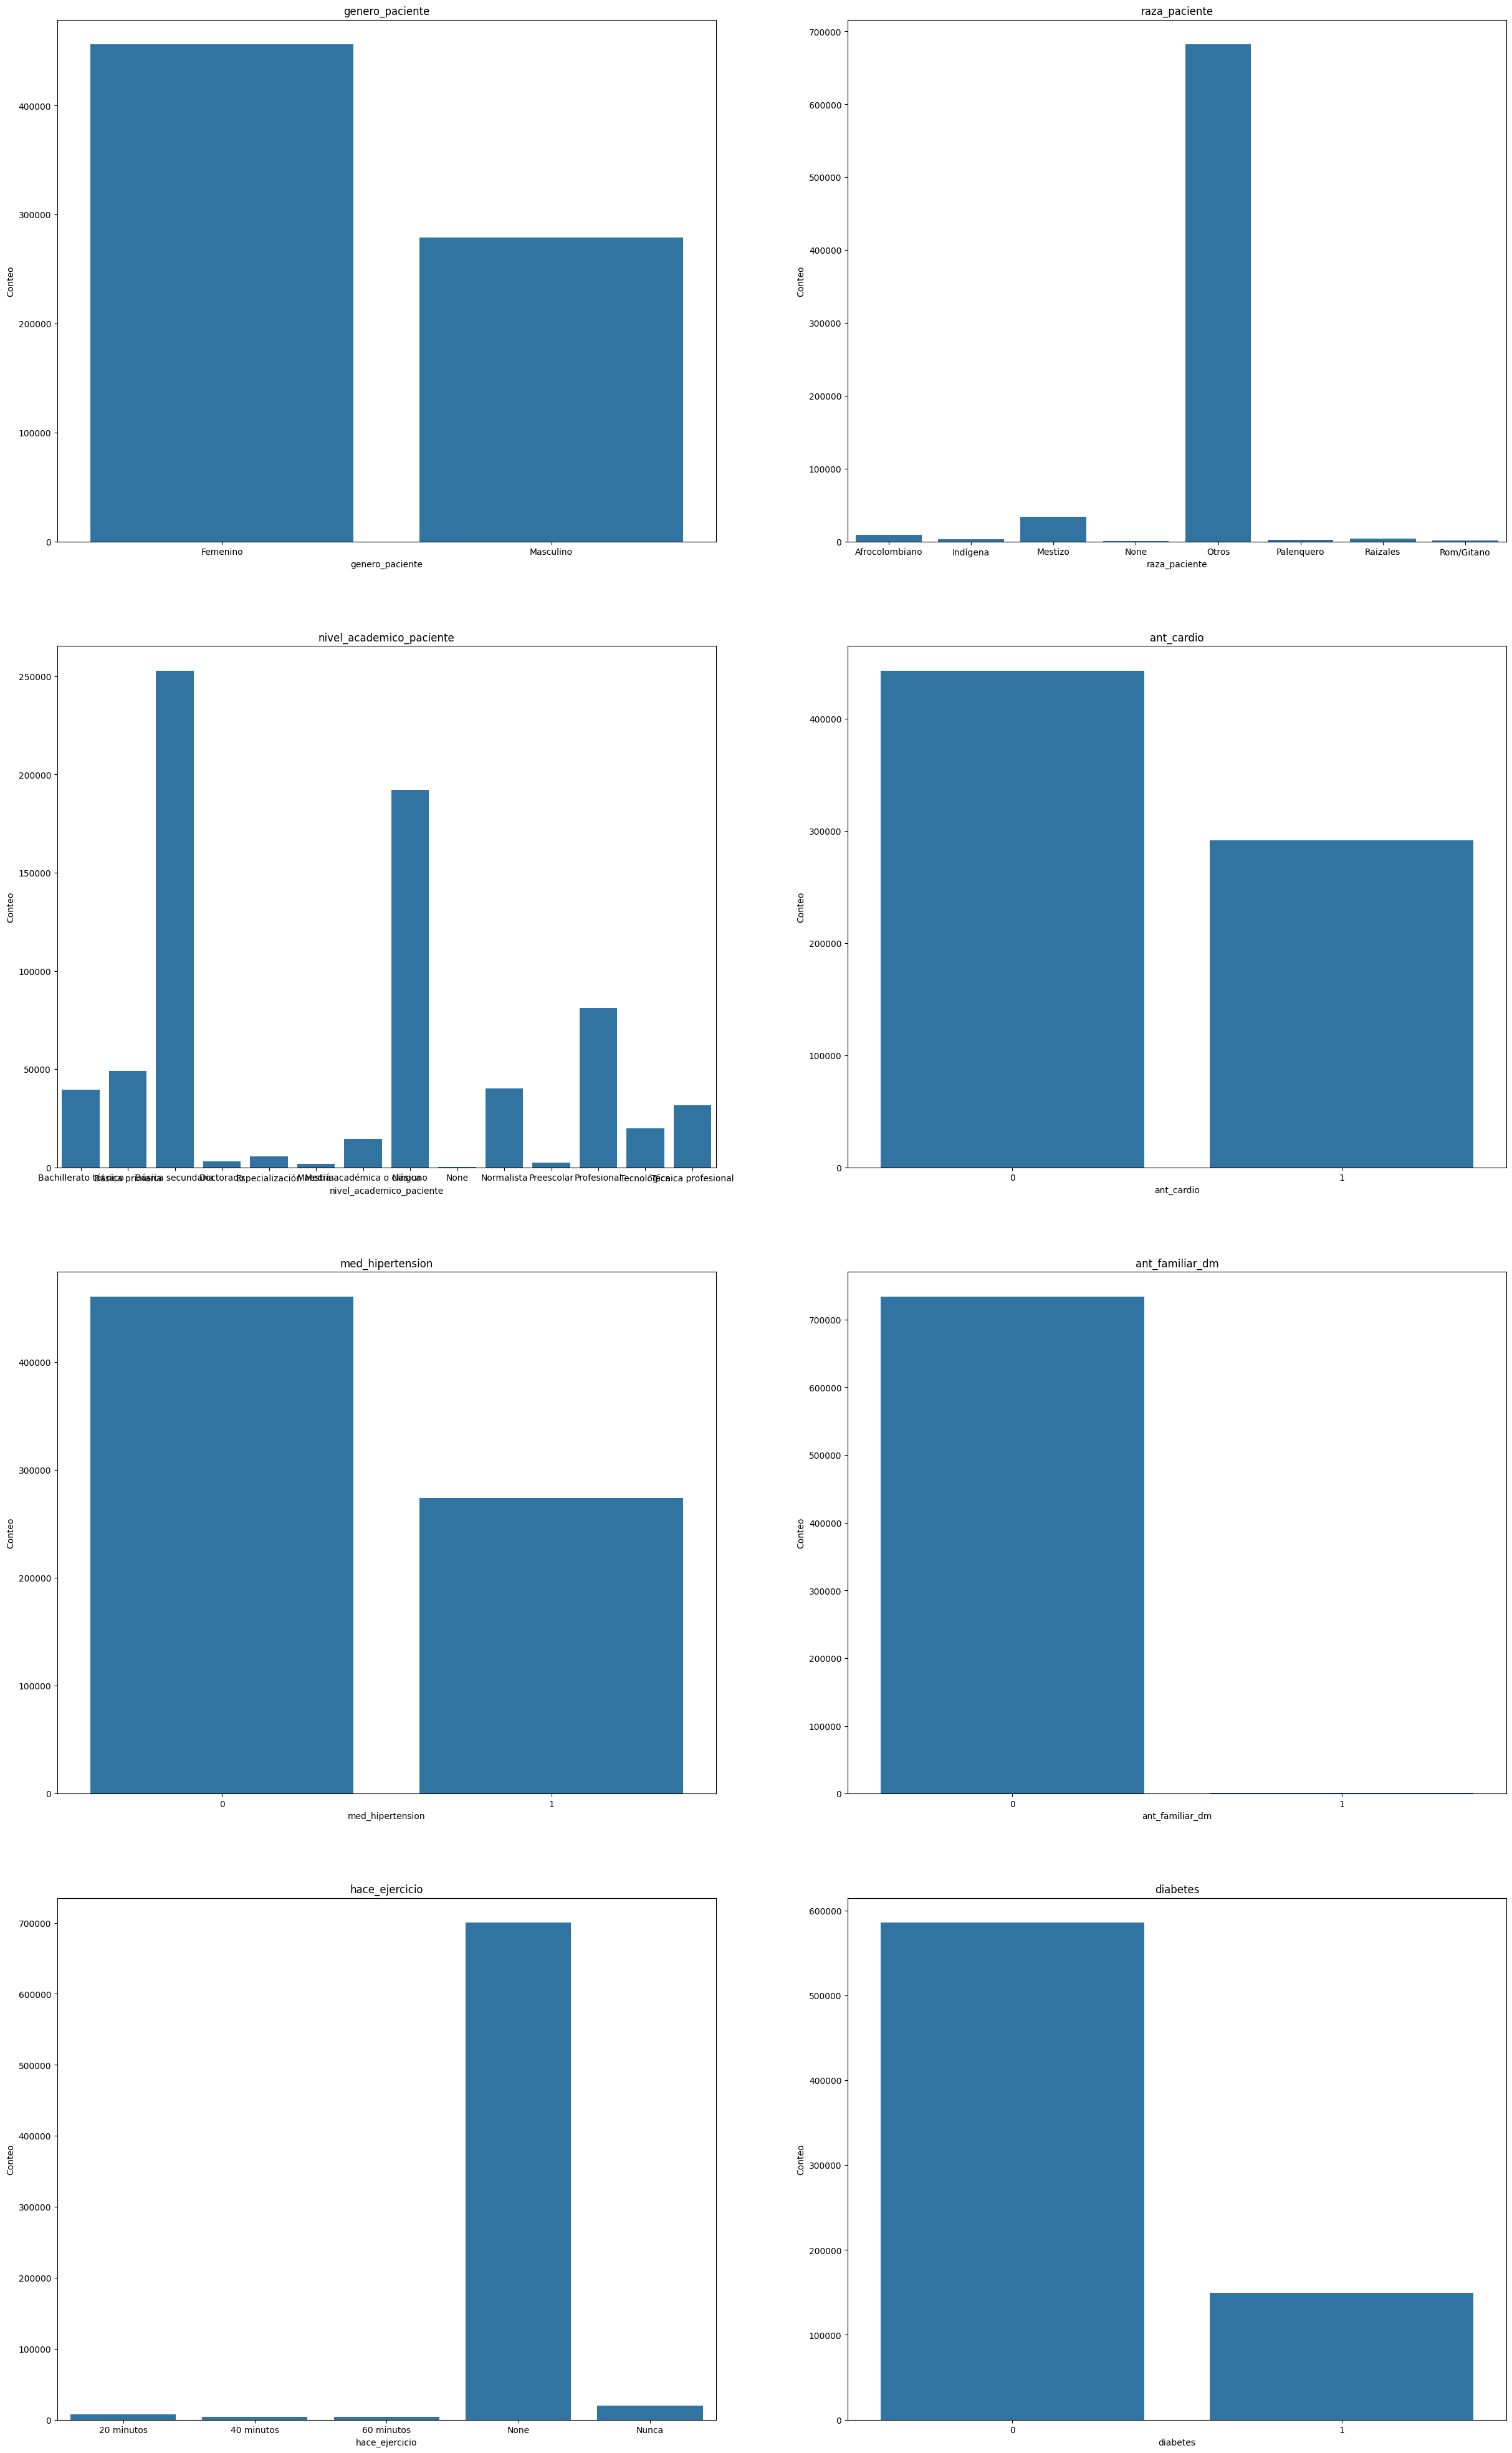

In [41]:
print('Conteos de cada una de las categorias')
fig, axes = graficador.create_subplots_one_var_group(data = df_categorico, n_cols = 2, n_rows = 4, graph= sns.barplot, fig_size=(30,50))
plt.show()

## Two Variables

In [ ]:
print('Grafico de dispersion para cada par de variables')
sns.pairplot(df_numerico)

Grafico de dispersion para cada par de variables


In [ ]:
print('Matriz de correlaciones')
px.imshow(np.round(df_numerico.corr(),2), text_auto=True, height=500, width=700)

In [ ]:
print('Matriz de covarianza')
df_numerico.cov()

In [ ]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    
    # Crear tabla con el perfil columna
    pc = round((pivot/ pivot.loc['All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pc)
    ax.set_xlabel(var2)
    ax.set_ylabel(column)
    plt.legend()


plt.show()

In [ ]:
var2 = 'diabetes'

for column in df_categorico.columns:

    if column == var2:
        continue

    # Filtrar el df
    df_temp = df_categorico[[column,var2]][::]

    # Columna temporal para el conteo de los datos
    df_temp['temp'] = 0

    # Convertir a tipo str para la grafica
    df_temp.columns = df_temp.columns.astype(str)

    # Crear tabla de contingencia
    pivot = pd.pivot_table(df_temp, values = 'temp', index = column, columns = var2, aggfunc = 'count', margins = True)
    # Crear tabla con el perfil columna
    pf = round((pivot.T/ pivot.loc[:,'All'].values)*100,2).iloc[:-1]

    # Crear grafico de barras apiladas del perfil columna
    fig, ax = create_apilated_bars(pf)
    ax.set_xlabel(column)
    ax.set_ylabel(var2)
    plt.legend()


plt.show()